## Train QuickNAT
Working code! Details coming soon!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.data_utils import get_data

from quickNat_pytorch.net_api import squeeze_excitation as se

#torch.set_default_tensor_type('torch.FloatTensor')
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

params ={
    'data' : {
        'base_dir' : "datasets/coronal",
        'train_data_file' : "Data_train.h5", 
        'train_label_file' : "Label_train.h5",
        'train_class_weights_file' : "Class_Weight_train.h5",        
        'train_weights_file' : "Weight_train.h5",                
        'test_data_file' : "Data_test.h5", 
        'test_label_file' : "Label_test.h5",         
        'test_class_weights_file' : "Class_Weight_test.h5",       
        'test_weights_file' : "Weight_test.h5",
        'labels' : ['Background','Left WM','Left Cortex','Left Lateral ventricle','Left Inf LatVentricle','Left Cerebellum WM','Left Cerebellum Cortex',
                    'Left Thalamus','Left Caudate','Left Putamen','Left Pallidum','3rd Ventricle','4th Ventricle','Brain Stem','Left Hippocampus',
                    'Left Amygdala','CSF (Cranial)','Left Accumbens','Left Ventral DC','Right WM','Right Cortex','Right Lateral Ventricle',
                    'Right Inf LatVentricle','Right Cerebellum WM','Right Cerebellum Cortex','Right Thalamus','Right Caudate','Right Putamen',
                    'Right Pallidum','Right Hippocampus','Right Amygdala','Right Accumbens','Right Ventral DC']
    },
    'network' : { 
        'num_class': 33,
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'se_block' : se.SELayer.NONE, # Valid options : se.SELayer.NONE, se.SELayer.CSE, se.SELayer.SSE, se.SELayer.CSSE
        'drop_out' : 0 # Keep 0 for no dropout        
    },
    'training' : {
        'model_name' : 'quicknat',
        'learning_rate': 1e-2,
        'train_batch_size': 2,
        'val_batch_size': 5,
        'log_nth': 50,
        'num_epochs': 10,
        'lr_scheduler_step_size': 5,
        'lr_scheduler_gamma' : 0.5,
        'exp_dir_name': 'Exp01_try1',
        'final_model_path': 'models/quicknat_model.model',
        'use_last_checkpoint':True #Uses the last checkpoint file from the exp_dir_name folder
    }
}

train_params, net_params, data_params = params['training'], params['network'], params['data']

## Load Data

In [2]:
train_data, test_data = get_data(data_params)
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 799
Test size: 763


## Train Model

In [4]:
from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_params['train_batch_size'], shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=train_params['val_batch_size'], shuffle=False, num_workers=4)

quicknat_model = quickNAT(params['network'])
solver = Solver(num_class = net_params['num_class'], optim_args={"lr": train_params['learning_rate']}, model_name = train_params['model_name'], labels = data_params['labels'])
solver.train(quicknat_model, train_loader, val_loader, 
             log_nth=train_params['log_nth'], 
             num_epochs=train_params['num_epochs'], 
             exp_dir_name=train_params['exp_dir_name'], 
             lr_scheduler_step_size = train_params['lr_scheduler_step_size'], 
             lr_scheduler_gamma = train_params['lr_scheduler_gamma'],
             use_last_checkpoint =train_params['use_last_checkpoint'])

START TRAIN.
train : [iteration : 50] : 9131222106112.0
train : [iteration : 100] : 8.235671945530573e+19
train : [iteration : 150] : 1.6230669042078188e+18
train : [iteration : 200] : 5580528853975040.0
train : [iteration : 250] : 2080591142977536.0
train : [iteration : 300] : 448480250167296.0
train : [iteration : 350] : 9.110341142007775e+18
train : [iteration : 400] : 9.051304789299692e+17
(256, 256) (256, 256)
(256, 256) (256, 256)
[Epoch : 7/10] : train loss = 9.051304789299692e+17, val loss = 2.14563878629e+18
Saving model... models/Exp01_try1/quicknat_epoch7.model
train : [iteration : 600] : 8.330679893493652
train : [iteration : 650] : 2.1429035663604736
train : [iteration : 700] : 1.5848972797393799
train : [iteration : 750] : 1.4376325607299805
train : [iteration : 800] : 1.3379788398742676
train : [iteration : 850] : 1.3514447212219238
train : [iteration : 900] : 1.1928558349609375
train : [iteration : 950] : 1.2745083570480347
(256, 256) (256, 256)
(256, 256) (256, 256)
[E

## Save the Model

When you are satisfied with your training, you can save the model.

In [40]:
quicknat_model.save(train_params['final_model_path'])

Saving model... models/quicknat_model.model


## Deploy Model on Test Data

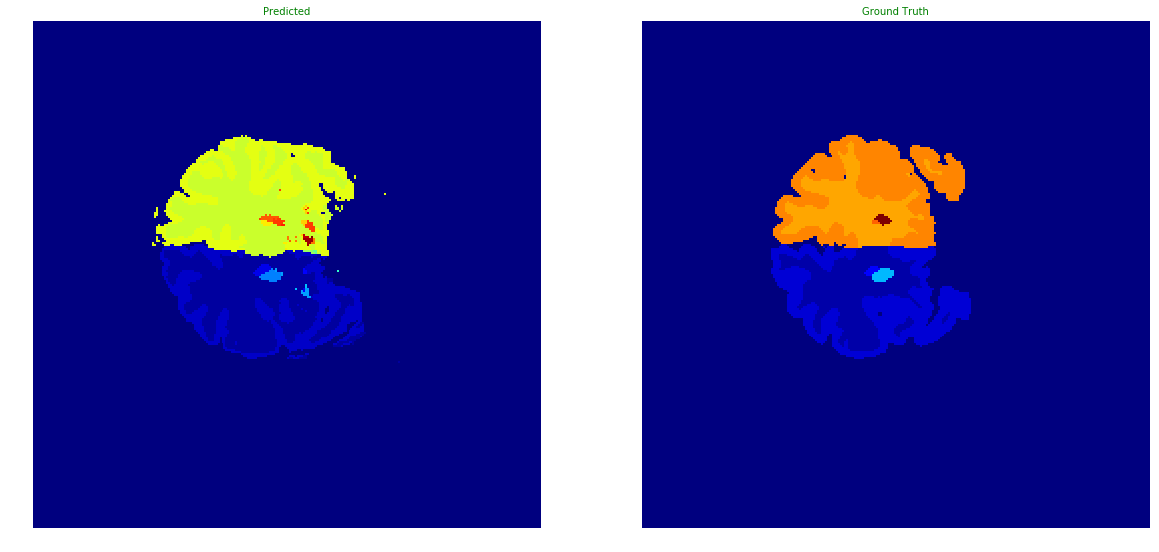

In [20]:
import matplotlib.pyplot as plt

quick_model = torch.load(train_params['final_model_path'])
with torch.no_grad():
    test_input = Variable(torch.Tensor(test_data.X[500:501]).cuda())
    out = quick_model.predict(test_input)
    
groud_truth = test_data.y[500:501]
groud_truth = np.squeeze(groud_truth)    


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
ax[0].imshow(out, cmap ='jet')

ax[0].set_title("Predicted", fontsize=10, color = "green")
ax[0].axis('off')
ax[1].imshow(groud_truth, cmap ='jet')
ax[1].set_title("Ground Truth", fontsize=10, color = "green")
ax[1].axis('off')
plt.show()